In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342
┌ Warning: Package ReactiveMPPaperExperiments does not have ReactiveMP in its dependencies:
│ - If you have ReactiveMPPaperExperiments checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMPPaperExperiments
└ Loading ReactiveMP into ReactiveMPPaperExperiments from project dependency, future warnings for ReactiveMPPaperExperiments are suppressed.


In [3]:
using CairoMakie # Plots related stuff
using Turing, MCMCChains, Distributions, LinearAlgebra, Random # Bayesian Inference packages
using BenchmarkTools, DataFrames, Query # Analysis tools

import ReactiveMP # For collect_results

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1342


This demo aligns with similar demo ReactiveMP.jl and skips most of the explanations. For a rigorous description and model explanation check corresponding ReactiveMP.jl demo

### Data

In [4]:
params = let
    # Seed for reproducability
    seed = 42
    
    # Number of IID samples
    n = 250
    
    # Number of mixture components
    nmixtures = 6
    
    # Mixture component mean distance from zero
    cdistance = 10
    
    # Angle change rate
    angle = 1.5π / nmixtures
    
    @strdict seed n nmixtures cdistance angle
end;

In [5]:
y, mixtures = generate_data(GMMModel(), params);

┌ Warning: /Users/bvdmitri/.julia/dev/ReactiveMP/src/rules/gcv/gaussian_extension.jl no longer exists, deleted all methods
└ @ Revise /Users/bvdmitri/.julia/packages/Revise/OgnOk/src/packagedef.jl:650


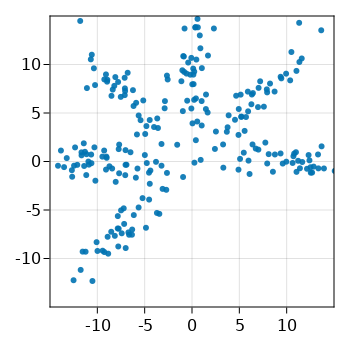

In [6]:
let
    @unpack seed, nmixtures, cdistance, angle, n = params
    
    sdim    = (n) -> (a) -> map(d -> d[n], a)
    limits  = (-1.5cdistance, 1.5cdistance)

    fig = Figure(resolution = (350, 350))
    ax = Makie.Axis(fig[1, 1])

    ax.xticks = [ -10, -5, 0, 5, 10 ]
    ax.yticks = [ -10, -5, 0, 5, 10 ]

    xlims!(ax, limits)
    ylims!(ax, limits)

    palette = fig.scene.palette.color[]

    scatter!(ax, 
        y |> sdim(1), y |> sdim(2), 
        markersize = 6, color = (palette[1], 0.9), 
        label = "Observations"
    )

    @saveplot fig "gmm_data"
end

### Model specification

In [7]:
@model function GaussianMixtureModel(y, nmixtures)
    n = length(y)
    k = length(first(y))
    
    @assert k === 2

    z = Vector(undef, n)
    m = Vector(undef, nmixtures)
    w = Vector(undef, nmixtures)
    
    for i in 1:nmixtures
        m[i] ~ MvNormal(zeros(2), [ 1e3 0.0; 0.0 1e3 ])
        w[i] ~ InverseWishart(2, [ 1e3 0.0; 0.0 1e3 ])
    end
    
    s ~ Dirichlet(nmixtures, 1.0)

    # Draw assignments for each datum and generate it from a multivariate normal.
    z = Vector(undef, n)
    
    for i in 1:n
        z[i] ~ Categorical(s)
        y[i] ~ MvNormal(m[z[i]], w[z[i]])
    end
end;

In [8]:
gmm_model = GaussianMixtureModel(y, 6);

In [48]:
gmm_sampler = Gibbs(PG(120, :z), HMC(0.05, 100, :m, :w))

Gibbs{(:z, :m, :w), Tuple{PG{(:z,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}, HMC{Turing.Core.ForwardDiffAD{40}, (:m, :w), AdvancedHMC.UnitEuclideanMetric}}}((PG{(:z,), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}(120, AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}(AdvancedPS.resample_systematic, 0.5)), HMC{Turing.Core.ForwardDiffAD{40}, (:m, :w), AdvancedHMC.UnitEuclideanMetric}(0.05, 100)))

In [ ]:
tchain = sample(gmm_model, gmm_sampler, 1000);

Sampling:  19%|███████▊                                 |  ETA: 3:01:25

In [13]:
smr = Turing.summarize(tchain, Turing.mean, Turing.std)


  parameters         mean       std 
      Symbol      Float64   Float64 

     m[1][1]     -25.8244    0.0000
     m[1][2]     -18.3333    0.0000
     m[2][1]      27.9125    0.0000
     m[2][2]       6.5995    0.0000
     m[3][1]      16.3715    0.0000
     m[3][2]      23.9197    0.0000
     m[4][1]      44.0806    0.0000
     m[4][2]      11.8819    0.0000
     m[5][1]     -39.4805    0.0000
     m[5][2]     -18.0444    0.0000
     m[6][1]     -22.8473    0.0000
     m[6][2]     -28.6641    0.0000
   w[1][1,1]   22390.7230    0.0000
   w[1][2,1]   -5231.0515    0.0000
   w[1][1,2]   -5231.0515    0.0000
   w[1][2,2]    1836.5095    0.0000
   w[2][1,1]   15852.2144    0.0000
   w[2][2,1]   21332.1480    0.0000
   w[2][1,2]   21332.1480    0.0000
   w[2][2,2]   32276.8782    0.0000
   w[3][1,1]   14557.4326    0.0000
   w[3][2,1]    3174.9669    0.0000
   w[3][1,2]    3174.9669    0.0000
      ⋮            ⋮           ⋮
                     269 rows omitted


In [12]:
mixtures[1] |> mean

2-element Vector{Float64}:
 10.0
  0.0

In [37]:
function extract_clusters(summary, dim, nmixtures)
    means = []
    covs  = []
    
    for nmx in 1:nmixtures
        mean = zeros(dim)
        cov  = zeros(dim, dim)
        for d in 1:dim
            mean[d] = summary[Symbol("m[$nmx][$d]")].nt.mean[1]
            for j in 1:dim
                 cov[d, j] = summary[Symbol("w[$nmx][$d,$j]")].nt.mean[1]
            end
        end
        
        push!(means, mean)
        push!(covs, cov)
    end
    
    return map(e -> MvNormal(e[1], e[2]), zip(means, covs))
end

extract_clusters (generic function with 1 method)

In [41]:
clusters = extract_clusters(smr, 2, 6);

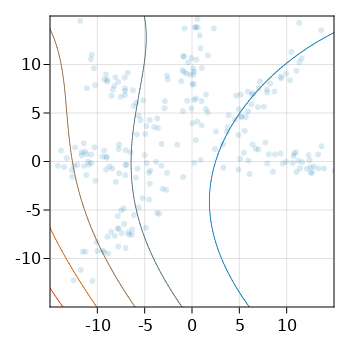

In [45]:
let
    @unpack seed, nmixtures, cdistance, angle = params
    
    sdim    = (n) -> (a) -> map(d -> d[n], a)
    limits  = (-1.5cdistance, 1.5cdistance)
    sigmoid = (x) -> 1 / (1 + exp(-x))

    fig = Figure(resolution = (350, 350))
    ax = Makie.Axis(fig[1, 1])

    ax.xticks = [ -10, -5, 0, 5, 10 ]
    ax.yticks = [ -10, -5, 0, 5, 10 ]

    xlims!(ax, limits)
    ylims!(ax, limits)

    palette = fig.scene.palette.color[]

    scatter!(ax, 
        y |> sdim(1), y |> sdim(2), 
        markersize = 6, color = (palette[1], 0.15), 
        label = "Observations"
    )

    crange  = range(-2cdistance, 2cdistance, step = 0.25)
    mixing  = ones(nmixtures) ./ nmixtures # mean(mixing_estimated)

    mixture = Distributions.MixtureModel(clusters, mixing)

    c = Makie.wong_colors()

    cobj = contour!(ax, 
        crange, crange, (x, y) -> pdf(mixture, [ x, y ]), 
        levels = 7, colorbar = true, linewidth = 0.8, overdraw = true,
        colormap = cgrad([ c[1], c[6], :red3 ])
    )

    # Colorbar(fig[1, 2], cobj)

    @saveplot fig "gmm_inference_turing"
end